### Imports

In [1]:
import os, re, math, json, shutil, pprint, datetime
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.platform import tf_logging
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.2.0-rc2


### Cloud project setup and colab authentication

In [0]:
from google.colab import auth
auth.authenticate_user()

In [33]:
!gcloud config set project srgan-deploy

Updated property [core/project].


In [34]:
!gcloud ai-platform models list

NAME          DEFAULT_VERSION_NAME
srgan_mse     version_1
srgan_perpix  version_3


In [0]:
# !gcloud components update

### Configuration

In [0]:
REGION = "us-central1"
BUCKET_NAME = "srgan-deploy-aiplatform-2"
PROJECT = "srgan-deploy"


In [0]:
MODEL_VERSION = "version_3_nogpu" #@param {type:"string"}

MODEL_NAME = "srgan_perpix"
### Saved model path
MODEL_BINARIES = "gs://srgan-deploy-aiplatform/export_saved_model/gan_estimator_export/version_3/"
NEW_MODEL = False #@param {type:"boolean"}


### Create bucket on google cloud storage

In [0]:
# !gsutil mb -l {REGION} gs://{BUCKET_NAME}

In [0]:
# !gsutil cp -r ./dir gs://{BUCKET_NAME}

### Deploy the model
This uses the command-line interface. You can do the same thing through the ML Engine UI at https://console.cloud.google.com/mlengine/models


In [0]:
# Create the model
if NEW_MODEL:
  !gcloud ai-platform models create {MODEL_NAME} --project={PROJECT} --regions={REGION} 
  # !gcloud ml-engine models create {MODEL_NAME} --project={PROJECT} --regions=us-central1

Created ml engine model [projects/srgan-deploy/models/srgan_perpix].


In [0]:
# Create a version of this model (you can add --async at the end of the line to make this call non blocking)
# Additional config flags are available: https://cloud.google.com/ml-engine/reference/rest/v1/projects.models.versions
# You can also deploy a model that is stored locally by providing a --staging-bucket=... parameter
!echo "Deployment takes a couple of minutes. You can watch your deployment here: https://console.cloud.google.com/ai-platform/models/"

!gcloud ai-platform versions create {MODEL_VERSION} \
    --model={MODEL_NAME} \
    --origin={MODEL_BINARIES} \
    --project={PROJECT} \
    --runtime-version=1.15 \
    --python-version=3.7

# !gcloud ml-engine versions create {MODEL_VERSION} --model={MODEL_NAME} --origin={export_path} --project={PROJECT} --runtime-version=1.10

Deployment takes a couple of minutes. You can watch your deployment here: https://console.cloud.google.com/ai-platform/models/


#### GPU deployment

In [0]:
# gcloud beta ai-platform versions create version_name \
#   --model model_name \
#   --origin gs://model-directory-uri \
#   --runtime-version 2.1 \
#   --python-version 3.7 \
#   --framework tensorflow \
#   --machine-type n1-standard-4 \
#   --accelerator count=1,type=nvidia-tesla-t4 \
#   --config config.yaml

### Test the deployed model
Your model is now available as a REST API. Let us try to call it. The cells below use the "gcloud ai-platform"
command line tool but any tool that can send a JSON payload to a REST endpoint will work.

In [13]:
!pip install tensorflow-gan

     |████████████████████████████████| 368kB 43.2MB/s 


In [14]:

import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import matplotlib.pyplot as plt
import numpy as np

In [15]:
predict_ds = tfds.load(name='lfw' , split='train' )

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incomplete4ZMEJ5/lfw-train.tfrecord



Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [16]:
predict_ds_2 = predict_ds.map(lambda features : features['image'] )
predict_ds_2

<DatasetV1Adapter shapes: (250, 250, 3), types: tf.uint8>

In [19]:
predict_ds_batch = predict_ds_2.batch(1, drop_remainder=True)
predict_ds_batch

<DatasetV1Adapter shapes: (1, 250, 250, 3), types: tf.uint8>

Low resolution images prediction batch 


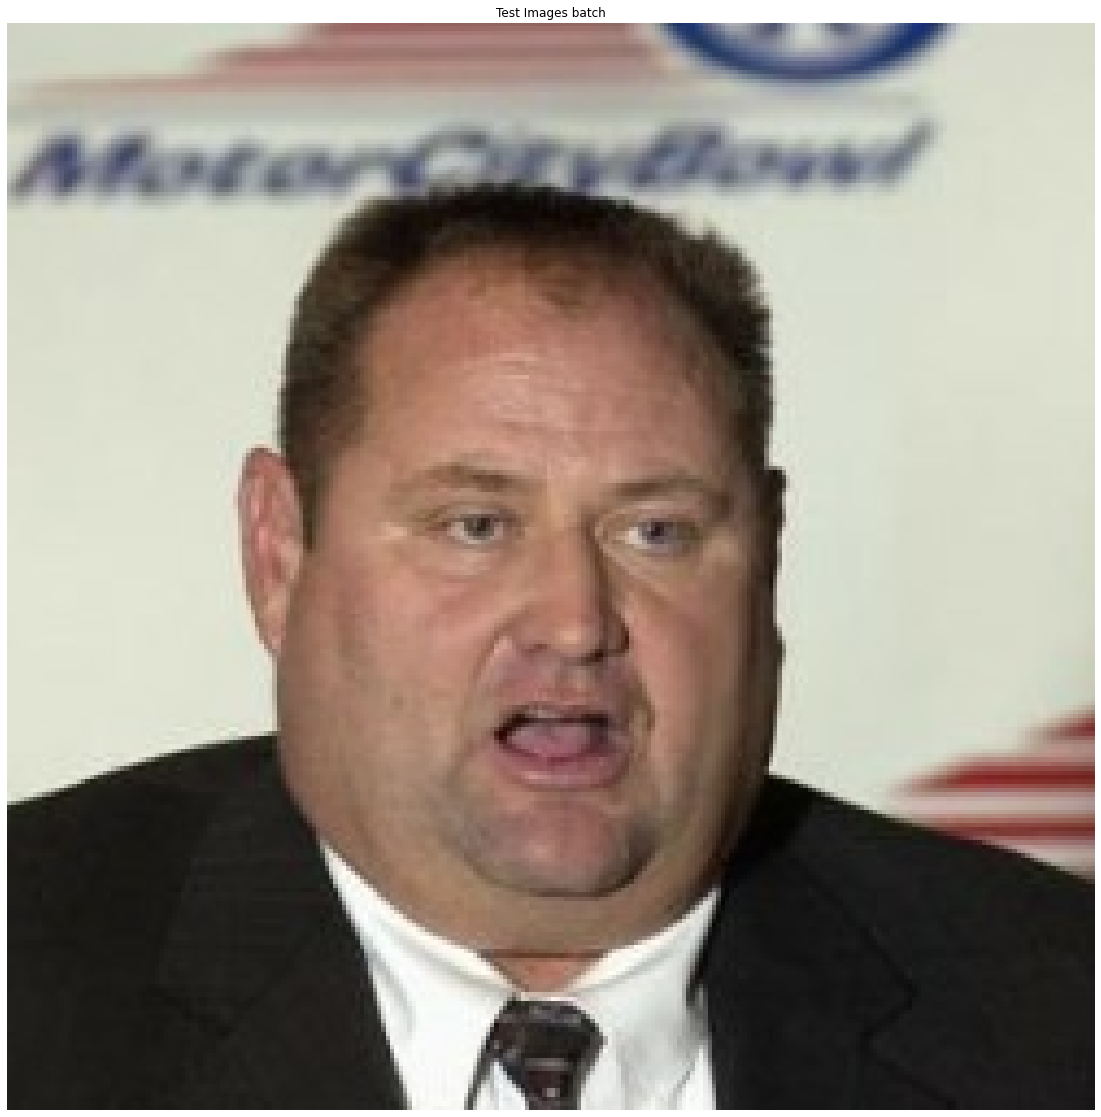

Test images size : (1, 250, 250, 3) 


In [20]:
test_imgs = next(tfds.as_numpy(predict_ds_batch))
test_imgs = test_imgs/255.0

test_imgs_grid = tfgan.eval.python_image_grid(test_imgs , grid_shape=(1, 1))
print('Low resolution images prediction batch ')
plt.figure(figsize=(20,20))
plt.axis('off')
plt.title('Test Images batch')
plt.imshow(np.squeeze(test_imgs_grid))
plt.show()

print("Test images size : {} " .format(test_imgs.shape))

In [0]:

with open("images.json", "w") as file_name:
  for img in test_imgs:
    # the format for ML Engine online predictions is: one JSON object per line
    input_data = json.dumps({"feature": img.tolist()})  
    file_name.write(input_data+'\n')

In [22]:
with open("images.json") as f2:
  file_contents = json.load(f2)

file_contents_list = file_contents['feature']

file_contents_list_array = np.array(file_contents_list)
file_contents_list_array.shape

(250, 250, 3)

#### Online predictions

In [0]:
# !gsutil cp images.json gs://{BUCKET_NAME}/test/images.json

In [0]:
# Request online predictions from deployed model (REST API) using the "gcloud ml-engine" command line.
# predictions = !gcloud ml-engine predict --model={MODEL_NAME} --json-instances digits.json --project={PROJECT} --version {MODEL_VERSION}

predictions = !gcloud ai-platform predict --project={PROJECT} --model={MODEL_NAME} --version {MODEL_VERSION}  --json-instances images.json


In [0]:
predictions

#### BATCH PREDICTION

In [26]:
# send the json to google cloud storage

### First remove previous file
!gsutil rm gs://{BUCKET_NAME}/test/images.json

### Send json to google cloud bucket

!gsutil cp images.json gs://{BUCKET_NAME}/test/images.json



Removing gs://srgan-deploy-aiplatform-2/test/images.json...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              
Copying file://images.json [Content-Type=application/json]...
/ [1 files][  3.7 MiB/  3.7 MiB]                                                
Operation completed over 1 objects/3.7 MiB.                                      


In [0]:
# Set the  job name, input and output paths

JOB_NAME= "batch_prediction_perpix3"

INPUT_JSON_PATH = "gs://" + str(BUCKET_NAME) + "/test/images.json"

OUTPUT_PATH= "gs://" + str(BUCKET_NAME) + "/" + str(JOB_NAME)

In [39]:
print(INPUT_JSON_PATH)
print(OUTPUT_PATH)

gs://srgan-deploy-aiplatform-2/test/images.json
gs://srgan-deploy-aiplatform-2/batch_prediction_perpix3


In [40]:
## SUBMIT THE BATCH PREDICTION

!gcloud ai-platform jobs submit prediction {JOB_NAME} \
    --model {MODEL_NAME} \
    --version {MODEL_VERSION} \
    --data-format text \
    --region {REGION} \
    --input-paths {INPUT_JSON_PATH} \
    --output-path {OUTPUT_PATH}/predictions

Job [batch_prediction_perpix3] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe batch_prediction_perpix3

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs batch_prediction_perpix3
jobId: batch_prediction_perpix3
state: QUEUED


In [0]:
## To see the job description

!gcloud ai-platform jobs describe {JOB_NAME}

In [0]:
# To see the logs of submitted job

!gcloud ai-platform jobs stream-logs {JOB_NAME}

#### Visualize the predictions

In [0]:
# To look at the results

!gsutil cat {OUTPUT_PATH}/predictions/prediction.results-00000-of-00001

In [0]:
!mkdir -p ./tmp_folder/{JOB_NAME}/

In [42]:
!gsutil cp -r {OUTPUT_PATH}/predictions ./tmp_folder/{JOB_NAME}/

Copying gs://srgan-deploy-aiplatform-2/batch_prediction_perpix3/predictions/prediction.errors_stats-00000-of-00001...
Copying gs://srgan-deploy-aiplatform-2/batch_prediction_perpix3/predictions/prediction.results-00000-of-00001...
- [2 files][ 60.9 MiB/ 60.9 MiB]                                                
Operation completed over 2 objects/60.9 MiB.                                     


In [43]:
!ls -r ./tmp_folder/{JOB_NAME}/predictions/

prediction.results-00000-of-00001  prediction.errors_stats-00000-of-00001


In [44]:
!pip install ijson

     |████████████████████████████████| 102kB 12.5MB/s 


In [0]:
import json
import pandas as pd
import ijson

In [0]:
json_output_file = "./tmp_folder/" + str(JOB_NAME) + "/predictions/prediction.results-00000-of-00001"

# with open("./tmp_folder/predictions/prediction.results-00000-of-00001") as f:
#   prediction = json.load(f)



In [0]:
data = []
with open(json_output_file, 'r') as f:
    objects = ijson.items(f, 'output')
    for row in objects:
            data.append(row)

In [49]:
super_resolution_images = np.array(data).astype(float)
# super_resolution_images = np.expand_dims(super_resolution_images, axis = 0)
super_resolution_images.shape

(1, 1000, 1000, 3)

Super resolution images of test images 


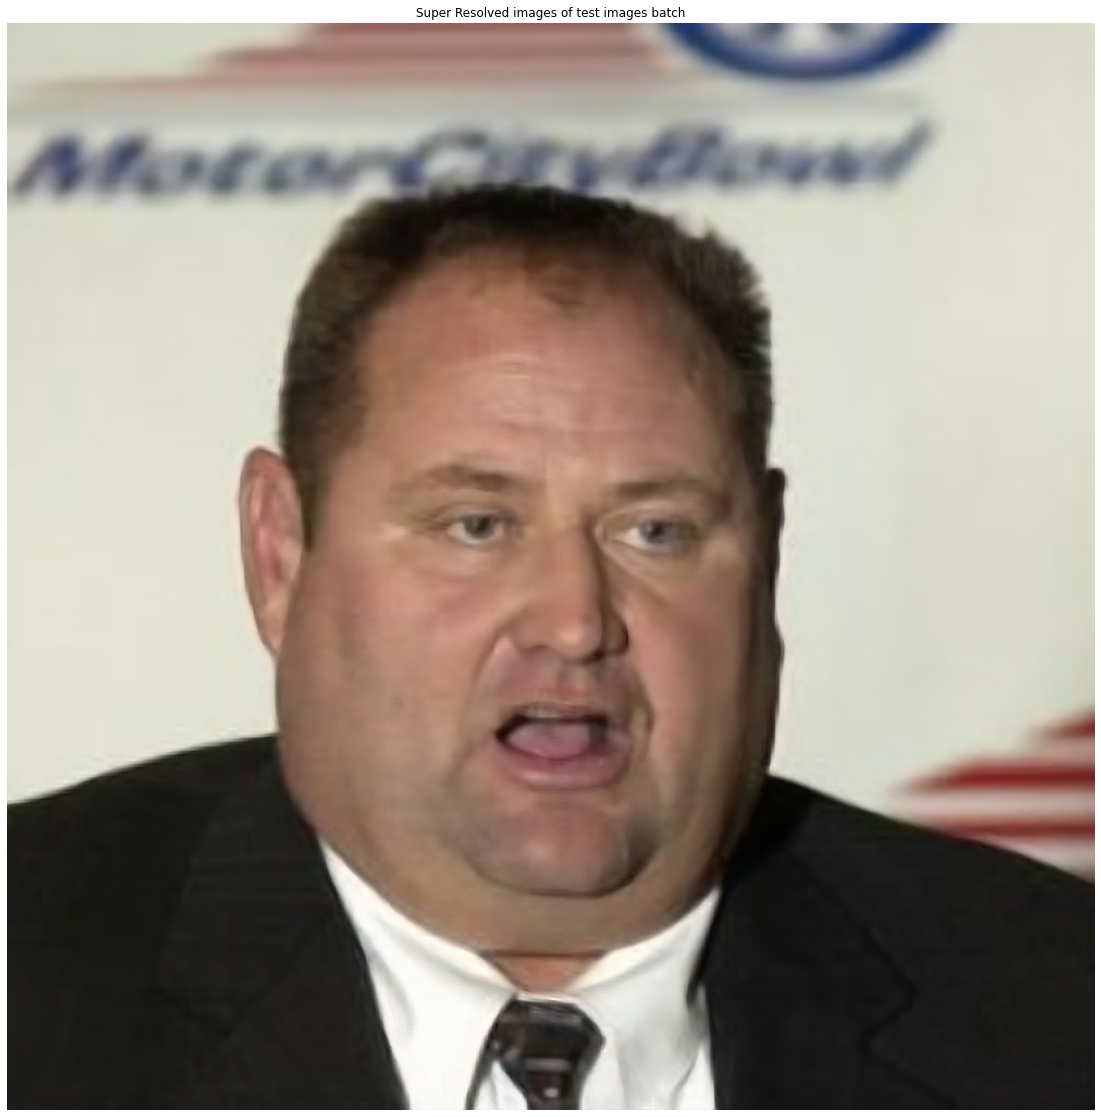

Super resolved images size : (1000, 1000, 3) 


In [50]:
pred_imgs_grid = tfgan.eval.python_image_grid( (super_resolution_images + 1.0)/2.0 , grid_shape=(1, 1))
print('Super resolution images of test images ')
plt.figure(figsize=(20,20))
plt.axis('off')
plt.title('Super Resolved images of test images batch')
plt.imshow(np.squeeze(pred_imgs_grid))
plt.show()

print("Super resolved images size : {} " .format(pred_imgs_grid.shape))